<a href="https://colab.research.google.com/github/joaogabrielanuto/quant-traders/blob/under-construction/estudos/codigo_joao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# ***Backtest Cruzamento mm com filtro "Afastamento da média"***
---

## **1. Importação das Libs**

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import mplfinance as mpf

---

## **2. Importação dos dados financeiros**

In [2]:
df = yf.download('^BVSP', interval='1d', start='2005-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,26193.0,26492.0,25671.0,25722.0,25722.0,0
2005-01-04,25722.0,25873.0,24791.0,24848.0,24848.0,0
2005-01-05,24859.0,25001.0,24523.0,24692.0,24692.0,0
2005-01-06,24695.0,24808.0,24250.0,24367.0,24367.0,0
2005-01-07,24376.0,24874.0,24376.0,24747.0,24747.0,0


---

## **3. Criar indicador "afastamento médio"**

Nosso indicador mostra a distância entre o valor médio do Candlestick para uma média móvel de período definido, sendo geralmente a média lenta.

**Passo a passo:**
* Calcular valor médio do Candle.
* Criar média móvel rápida (para backtest seguinte).
* Criar média móvel lenta (para indicador e backtest).
* Calcular distância entre Close e média longa.
* Criar uma média móvel de janela dinâmica expansiva do próprio indicador.

In [4]:
mm_rapida = 20
mm_lenta = 200
mm_afastamento = 20
banda_mm_afastamento = 1.0

df['Valor_medio'] = (df['Open'] + df['High'] + df['Low'] + df['Close'])/4
df['Media_rapida'] = df['Valor_medio'].rolling(mm_rapida).mean()
df['Media_lenta'] = df['Valor_medio'].rolling(mm_lenta).mean()
df['Media_afastamento'] = df['Valor_medio'].rolling(mm_afastamento).mean()
df['Dist_media'] = abs(df['Close'] - df['Media_afastamento'])
df['Dist_media_mm'] = df['Dist_media'].expanding().mean()

**Nota:** Vamos plotar um pedaço do nosso ativo para verificar como o indicador está se comportando

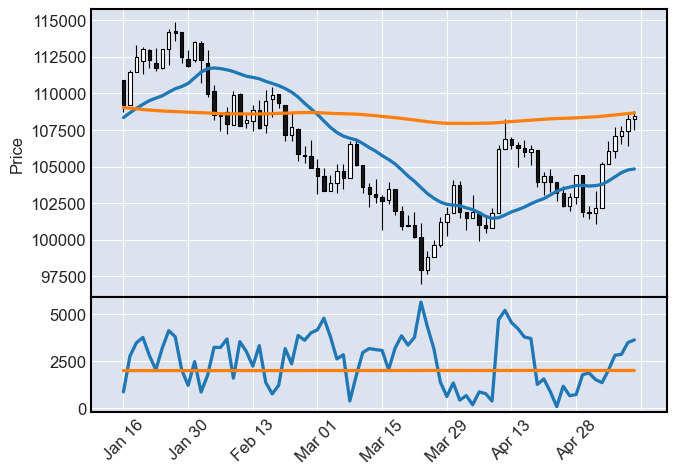

In [5]:
df_plot = df.iloc[-80:]
plot_ind = mpf.make_addplot(df_plot['Dist_media'], panel=1)
plot_ind_mm = mpf.make_addplot((df_plot['Dist_media_mm']*banda_mm_afastamento), panel=1)
plot_mm_10 = mpf.make_addplot(df_plot['Media_rapida'])
plot_mm_20 = mpf.make_addplot(df_plot['Media_lenta'])
mpf.plot(df_plot, type='candle', addplot=[plot_ind, plot_mm_10, plot_mm_20, plot_ind_mm])

---

## **4. Backtest**

**Regras do nosso tradingsytem:**

*OBS: Apenas trades de compra*

**Entrada:**
* Média rápida cruzar acima da média lenta
* Afastamento da média estar acima da própria média do indicador

**Saída:**
* Média rápida cruzar abaixo da média lenta

In [6]:
position = 0
dict_precos = {'entrada':[], 'data_ent':[], 'preco_ent':[], 'saida':[], 'data_sai':[], 'preco_sai':[]}

for i in range(len(df)):

    if (position==0) and (df['Media_rapida'].iloc[i] > df['Media_lenta'].iloc[i]) and (df['Media_rapida'].shift(1).iloc[i] < df['Media_lenta'].shift(1).iloc[i]) \
    and (df.Dist_media.iloc[i] > (df.Dist_media_mm.iloc[i]*banda_mm_afastamento)):
        dict_precos['entrada'].append('compra')
        dict_precos['data_ent'].append(df.index[i])
        dict_precos['preco_ent'].append(df.Close[i])
        position=1

    if (position==1) and (df['Media_rapida'].iloc[i] < df['Media_lenta'].iloc[i]) and (df['Media_rapida'].shift(1).iloc[i] > df['Media_lenta'].shift(1).iloc[i]):
        dict_precos['saida'].append('realiza')
        dict_precos['data_sai'].append(df.index[i])
        dict_precos['preco_sai'].append(df.Close[i])
        position=0

In [7]:
df_results = pd.DataFrame.from_dict(dict_precos, orient='index').transpose()
df_results = df_results.set_index('data_ent')

In [8]:
df_results['return'] = (df_results.preco_sai/df_results.preco_ent)
df_results.head()

,entrada,preco_ent,saida,data_sai,preco_sai,return
data_ent,,,,,,
2006-10-19,compra,38920.0,realiza,2008-07-14,60721.0,1.560149
2009-04-24,compra,46772.0,realiza,2010-05-21,60259.0,1.288356
2010-09-22,compra,68325.0,realiza,2011-02-18,68067.0,0.996224
2012-01-20,compra,62312.0,realiza,2012-05-23,54619.0,0.876541
2012-12-26,compra,60960.0,realiza,2013-03-04,56499.0,0.926821


**Nota:** Vamos plotar o primeiro trade para sabermos se está tudo em ordem.

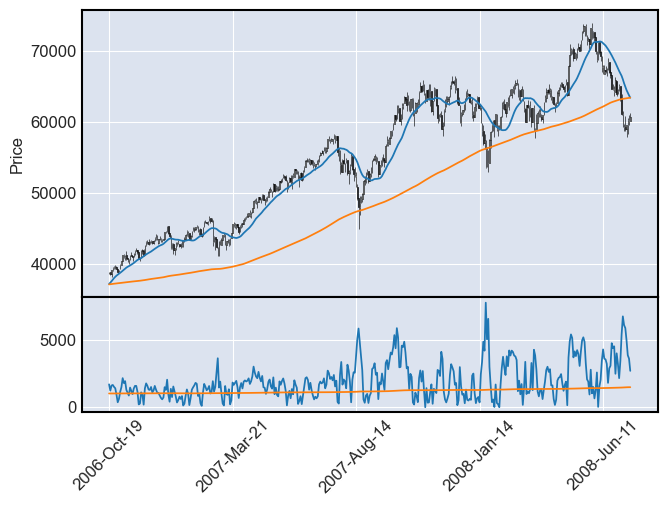

In [9]:
df_plot = df.loc['2006-10-19':'2008-07-14']
plot_ind = mpf.make_addplot(df_plot['Dist_media'], panel=1)
plot_ind_mm = mpf.make_addplot((df_plot['Dist_media_mm']**banda_mm_afastamento), panel=1)
plot_mm_10 = mpf.make_addplot(df_plot['Media_rapida'])
plot_mm_20 = mpf.make_addplot(df_plot['Media_lenta'])
mpf.plot(df_plot, type='candle', addplot=[plot_ind, plot_mm_10, plot_mm_20, plot_ind_mm])

## **6. Resultados**

### ***6.1 Resultado Acumulado***

<Axes: xlabel='data_ent'>

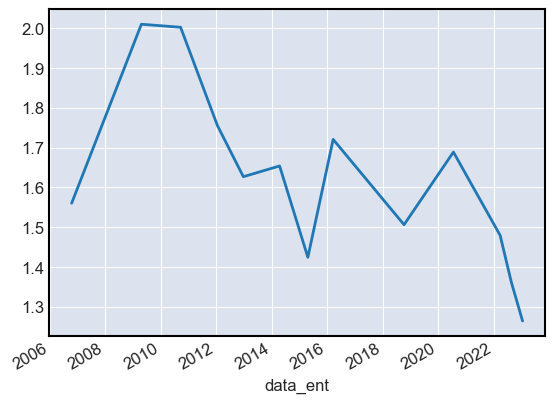

In [10]:
df_results['return'].cumprod().plot()

### ***6.2 Comparação com cruzamento sem filtro do indicador***

<Axes: xlabel='data_ent'>

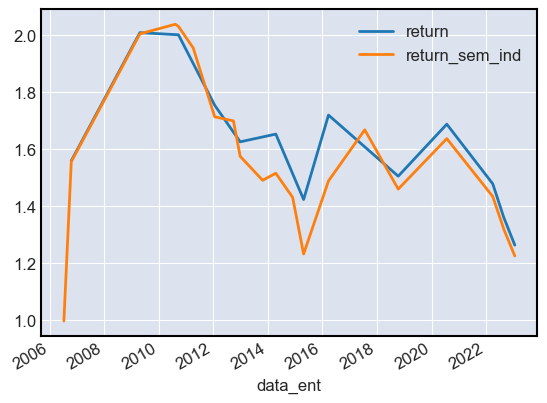

In [142]:
position = 0
dict_precos = {'entrada':[], 'data_ent':[], 'preco_ent':[], 'saida':[], 'data_sai':[], 'preco_sai':[]}

for i in range(len(df)):

  if (position==0) and (df.Media_rapida.iloc[i] > df.Media_lenta.iloc[i]) and (df.Media_rapida.shift(1).iloc[i] < df.Media_lenta.shift(1).iloc[i]):
    dict_precos['entrada'].append('compra')
    dict_precos['data_ent'].append(df.index[i])
    dict_precos['preco_ent'].append(df.Close[i])
    position=1

  if (position==1) and (df.Media_rapida.iloc[i] < df.Media_lenta.iloc[i]) and (df.Media_rapida.shift(1).iloc[i] > df.Media_lenta.shift(1).iloc[i]):
      dict_precos['saida'].append('realiza')
      dict_precos['data_sai'].append(df.index[i])
      dict_precos['preco_sai'].append(df.Close[i])
      position=0
    
df_results_2 = pd.DataFrame.from_dict(dict_precos, orient='index').transpose()
df_results_2 = df_results_2.set_index('data_ent')
df_results_2['resultado'] = (df_results_2.preco_sai - df_results_2.preco_ent)/df_results_2.preco_ent * 100
df_results_2['return_sem_ind'] = (df_results_2.preco_sai/df_results_2.preco_ent)

df_results['return'].cumprod().plot(legend=True)
df_results_2['return_sem_ind'].cumprod().plot(legend=True)

In [ ]:
df_merged = pd.merge(left=df_results, right=df_results_2, how='outer', left_index=True, right_index=True).head(30)

In [ ]:
df_merged

In [ ]:
df_plot = df.loc['2005-01-01':'2005-07-01']
plot_ind = mpf.make_addplot(df_plot['Dist_media'], panel=1)
plot_ind_mm = mpf.make_addplot((df_plot['Dist_media_mm']*1.2), panel=1)
plot_mm_10 = mpf.make_addplot(df_plot['Media_rapida'])
plot_mm_20 = mpf.make_addplot(df_plot['Media_lenta'])
mpf.plot(df_plot, type='candle', addplot=[plot_ind, plot_mm_10, plot_mm_20, plot_ind_mm])

In [ ]:
list